/Users/matthew/Documents/Efficient Gaussian Process on Graphs/Efficient_Gaussian_Process_On_Graphs/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iteration 1: X_next = -1.000, f(X_next) = -1.841
[[-0.9]
 [ 0. ]
 [ 1.1]]
Iteration 2: X_next = 2.000, f(X_next) = -2.879
[[-0.9]
 [ 0. ]
 [ 1.1]
 [-1. ]]
Iteration 3: X_next = 0.453, f(X_next) = 1.090
[[-0.9]
 [ 0. ]
 [ 1.1]
 [-1. ]
 [ 2. ]]
Iteration 4: X_next = 0.517, f(X_next) = 1.095
[[-0.9       ]
 [ 0.        ]
 [ 1.1       ]
 [-1.        ]
 [ 2.        ]
 [ 0.45345345]]
Iteration 5: X_next = 0.508, f(X_next) = 1.097
[[-0.9       ]
 [ 0.        ]
 [ 1.1       ]
 [-1.        ]
 [ 2.        ]
 [ 0.45345345]
 [ 0.51651652]]
Iteration 6: X_next = 0.508, f(X_next) = 1.097
[[-0.9       ]
 [ 0.        ]
 [ 1.1       ]
 [-1.        ]
 [ 2.        ]
 [ 0.45345345]
 [ 0.51651652]
 [ 0.50750751]]
Iteration 7: X_next = 0.505, f(X_next) = 1.097
[[-0.9       ]
 [ 0.        ]
 [ 1.1       ]
 [-1.        ]
 [ 2.        ]
 [ 0.45345345]
 [ 0.51651652]
 [ 0.50750751]
 [ 0.50750751]]
Iteration 8: X_next = 0.495, f(X_next) = 1.098
[[-0.9       ]
 [ 0.        ]
 [ 1.1       ]
 [-1.        ]
 [ 2.   

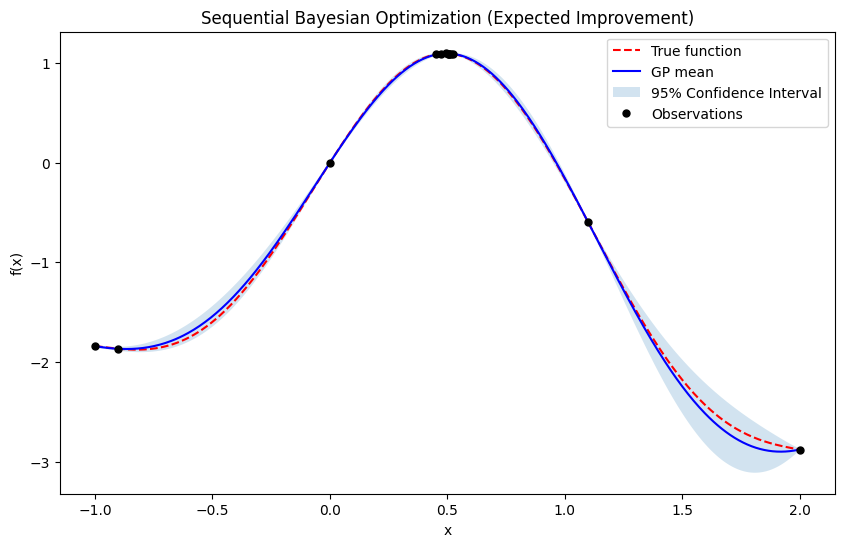

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# ---------------------------------------------------------
# 1. Define the 1D objective function we want to maximize
# ---------------------------------------------------------
def objective_function(x):
    """1D test function, with x as a numpy array of shape (n,1)."""
    return np.sin(3*x) - x**2 + 0.7*x

# ---------------------------------------------------------
# 2. Define the Expected Improvement (EI) acquisition function
# ---------------------------------------------------------
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """
    Calculates the Expected Improvement at points X based on
    existing samples (X_sample, Y_sample) using a Gaussian Process.
    
    Args:
        X: Points at which EI shall be computed, shape (n, 1).
        X_sample: Sample locations, shape (m, 1).
        Y_sample: Sample values, shape (m,).
        gpr: A fit GaussianProcessRegressor.
        xi: Exploration parameter (trade-off).
    
    Returns:
        EI: Expected Improvement at each point in X, shape (n,).
    """
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample_opt = np.max(Y_sample)  # best (max) so far among the samples

    # Clip to avoid numerical issues
    sigma = np.clip(sigma, 1e-9, None)

    # Z = (mu - f_best - xi) / sigma
    improvement = mu - mu_sample_opt - xi
    Z = improvement / sigma
    
    from scipy.stats import norm
    ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
    # For points where sigma is extremely small (GP is very certain),
    # we might end up with near-zero improvement. That is expected.
    return ei

# ---------------------------------------------------------
# 3. Sequential Bayesian Optimization Setup
# ---------------------------------------------------------

# Bounds (1D); let's define x in [-1, 2]
bounds = np.array([[-1.0, 2.0]])

# Some initial points (2D array with shape (n_init,1))
X_train = np.array([[-0.9],
                    [0.0],
                    [1.1]])
# Evaluate objective
y_train = objective_function(X_train).ravel()

# Create the GP with an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.5, length_scale_bounds=(1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=5)

n_iter = 10  # how many sequential samples

# ---------------------------------------------------------
# 4. The iterative (sequential) process
# ---------------------------------------------------------
for i in range(n_iter):
    # 4.1. Fit the Gaussian Process with the observed samples
    gp.fit(X_train, y_train)
    
    # 4.2. Define a set of candidate points in the range of interest
    X_candidates = np.linspace(bounds[0,0], bounds[0,1], 1000).reshape(-1,1)
    
    # 4.3. Compute the EI acquisition at each candidate
    ei = expected_improvement(X_candidates, X_train, y_train, gp, xi=0.01)
    
    # 4.4. Select the next point: the one with the maximum EI
    next_index = np.argmax(ei)
    X_next = X_candidates[next_index].reshape(1, -1)  # shape (1,1)
    
    # 4.5. Evaluate the objective function at X_next
    y_next = objective_function(X_next).ravel()
    
    # (Optional) Print or log the chosen point and its objective
    print(f"Iteration {i+1}: X_next = {X_next[0][0]:.3f}, f(X_next) = {y_next[0]:.3f}")
    
    # 4.6. Append the new sample to our dataset
    X_train = np.vstack((X_train, X_next))
    y_train = np.append(y_train, y_next)

# ---------------------------------------------------------
# 5. Plot the final GP fit + acquisition function (optional)
# ---------------------------------------------------------
# After the loop, let's see how the GP looks.
X_plot = np.linspace(bounds[0,0], bounds[0,1], 500).reshape(-1,1)
mu, std = gp.predict(X_plot, return_std=True)

plt.figure(figsize=(10, 6))

# True function
plt.plot(X_plot, objective_function(X_plot), 'r--', label="True function")

# GP mean
plt.plot(X_plot, mu, 'b-', label="GP mean")

# Confidence interval
plt.fill_between(X_plot.ravel(),
                 mu - 1.96*std,
                 mu + 1.96*std,
                 alpha=0.2,
                 label="95% Confidence Interval")

# Observed points
plt.plot(X_train, y_train, 'ko', label="Observations", markersize=5)

plt.title("Sequential Bayesian Optimization (Expected Improvement)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()
